# Mounting Google Drive

First add the data to your google drive using the following link:

https://drive.google.com/drive/u/1/folders/17SpWmNSl9dcbyqUFpdvnYlHj1EYXwHju

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installing Required Libraries


In [ ]:
!pip3 install transformers
!pip3 install unidecode

     |████████████████████████████████| 1.3MB 12.8MB/s 
     |████████████████████████████████| 2.9MB 47.3MB/s 
     |████████████████████████████████| 890kB 46.3MB/s 
     |████████████████████████████████| 1.1MB 48.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=7ebdef0e1ce671dcc367a00dd6b862997c4adee10cd0f3b4722cce940dd99ed3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 245kB 15.4MB/s 


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=751911c38052c9bbfee1e3273c4976c36746277b55632b50c19d3145e0978680
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  |     Proc size: 111.8 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total     15079MB


In [ ]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import join
import unidecode
import re
import logging
from tqdm.notebook import tnrange
import glob
import json

#For ploting results
import matplotlib.pyplot as plt

# DL Libraries
from transformers import BertModel, AdamW, BertTokenizer, BertConfig, RobertaTokenizer, RobertaModel
from keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print("device: {} n_gpu: {}".format(device, n_gpu)) 

device: cuda n_gpu: 1


In [ ]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)
print(logger)

<Logger __main__ (INFO)>


# Loading the data


In [ ]:
data_df= pd.read_csv('/content/drive/MyDrive/NLP/openBook_QA.csv')
train_df, test_df= train_test_split(data_df, test_size=0.2)

# Training the model


In [ ]:
def create_dataloader(tokenizer, df):
    input_ids= list()
    attention_masks= list()

    print("Shape: {}".format(df.shape))

    special_sentences_1 = [sentence for i, sentence in enumerate(df.question)]
    special_sentences_2 = [" [SEP] " + str(sentence) for i, sentence in enumerate(df.sentence)]
    special_sentences = [i + j for i, j in zip(special_sentences_1, special_sentences_2)]

    for sentence in special_sentences:
      encoded_text = tokenizer.encode_plus(sentence, max_length=512, add_special_tokens=True, return_token_type_ids=False, 
                                       padding='max_length', return_attention_mask=True, truncation=True)
      input_ids.append(encoded_text['input_ids'])
      attention_masks.append(encoded_text['attention_mask'])

    inputs = torch.tensor(input_ids).to(device)
    masks = torch.tensor(attention_masks).to(device)
    gold_labels = torch.tensor(df.sia_score.tolist()).to(device)
  
    data = TensorDataset(inputs, masks, gold_labels)
    sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=4)

    return dataloader

In [ ]:
#Dataloaders
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_dataloader= create_dataloader(tokenizer, train_df)
test_dataloader= create_dataloader(tokenizer, test_df)

11/29/2020 14:01:33 - INFO - filelock -   Lock 140322148789048 acquired on /root/.cache/torch/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock


11/29/2020 14:01:33 - INFO - filelock -   Lock 140322148789048 released on /root/.cache/torch/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
11/29/2020 14:01:33 - INFO - filelock -   Lock 140322148789552 acquired on /root/.cache/torch/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


11/29/2020 14:01:34 - INFO - filelock -   Lock 140322148789552 released on /root/.cache/torch/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock



Shape: (39656, 3)
Shape: (9914, 3)


In [ ]:
#Class for Regression
class Regressor(nn.Module):

  def __init__(self):
    super(Regressor, self).__init__()
    self.bert = RobertaModel.from_pretrained('roberta-base')
    self.out = nn.Linear(self.bert.config.hidden_size, 1)

  def forward(self, input_ids, attention_mask):
    output, pooler_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    score= self.out(pooler_out)
    return score

In [ ]:
epochs = 10

#Load Model
model= Regressor()
model.to(device)

# Prepare optimizer
optimizer = AdamW(model.parameters(),lr=2e-5)

#Loss Function
mse_loss= nn.MSELoss().to(device)

In [ ]:
output_dir= '/content/drive/My Drive/NLP/sia_experiment/SIA_OpenBookQA'
output_result= '/content/drive/My Drive/NLP/sia_experiment/results_OpenBookQA'

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

if not os.path.exists(output_result):
  os.makedirs(output_result)

In [ ]:
for iteration in tnrange(epochs, desc='Epochs'):
  model.train()
  logger.info("Running for iteration: {}".format(iteration+1))

  training_loss, training_steps = 0,0
  true_labels, predicted_labels = list(), list()
  
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    ip_ids, masks, gold_labels= batch
    score = model(ip_ids, attention_mask=masks)
    score = score.squeeze(1)
    loss= mse_loss(score, gold_labels.float())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    training_loss+=loss.item()
    training_steps+=1
    if (step+1)%10000 == 0:
      print(step+1)

    true_labels.extend(gold_labels.cpu().numpy())
    predicted_labels.extend(score.detach().cpu().numpy())
  
  training_loss_for_epoch= training_loss/training_steps
  pcc= pearsonr(true_labels, predicted_labels)
  rmse= mean_squared_error(true_labels, predicted_labels, squared=False)
  
  result = {'loss': training_loss_for_epoch, 'PCC': pcc[0], 'RMSE':rmse}
  print(result)

  model_to_save = model.bert.module if hasattr(model.bert, 'module') else model.bert
  model_to_save.save_pretrained(output_dir)

  torch.save(model.out.state_dict(), join(output_dir, 'model_state.bin'))

  #Testing
  print("Running evaluation for epoch: {}".format(iteration+1))

  true_labels, predicted_labels= list(), list()
  model.eval()
  with torch.no_grad():
    for step, batch in enumerate(test_dataloader):
      batch = tuple(t.to(device) for t in batch)
      ip_ids, masks, gold_labels= batch
      score = model(ip_ids, attention_mask=masks)
      score = score.squeeze(1)

      true_labels.extend(gold_labels.cpu().numpy())
      predicted_labels.extend(score.detach().cpu().numpy())
  
  pcc= pearsonr(true_labels, predicted_labels)
  rmse= mean_squared_error(true_labels, predicted_labels, squared=False)
  test_report= {'PCC': pcc[0], 'RMSE':str(rmse)}
  print(test_report)

  with open(join(output_result, 'result_'+str(iteration+1)+'.json'), 'w') as fp:
    json.dump(test_report, fp)

11/22/2020 20:13:04 - INFO - __main__ -   Running for iteration: 1


{'loss': 0.3064345034140899, 'PCC': 0.8810467503507045, 'RMSE': 0.55356526}
Running evaluation for epoch: 1


11/22/2020 21:32:20 - INFO - __main__ -   Running for iteration: 2


{'PCC': 0.9221502864335095, 'RMSE': '0.47410914'}
{'loss': 0.22119142406126535, 'PCC': 0.9156442534429209, 'RMSE': 0.47030994}
Running evaluation for epoch: 2


11/22/2020 22:51:42 - INFO - __main__ -   Running for iteration: 3


{'PCC': 0.9161333094168415, 'RMSE': '0.47007203'}
{'loss': 0.1777562570407368, 'PCC': 0.9328072655440851, 'RMSE': 0.4216115}
Running evaluation for epoch: 3


11/23/2020 00:11:03 - INFO - __main__ -   Running for iteration: 4


{'PCC': 0.9296943830942032, 'RMSE': '0.46470946'}
{'loss': 0.14786131402085434, 'PCC': 0.9444392980641698, 'RMSE': 0.3845274}
Running evaluation for epoch: 4


11/23/2020 01:30:25 - INFO - __main__ -   Running for iteration: 5


{'PCC': 0.9217391504211977, 'RMSE': '0.45488328'}
{'loss': 0.12898050446742068, 'PCC': 0.9517147860127269, 'RMSE': 0.35913855}
Running evaluation for epoch: 5


11/23/2020 02:49:48 - INFO - __main__ -   Running for iteration: 6


{'PCC': 0.9334019303531809, 'RMSE': '0.42901504'}
{'loss': 0.12751136212583758, 'PCC': 0.9522772988621568, 'RMSE': 0.3570873}
Running evaluation for epoch: 6


11/23/2020 04:09:09 - INFO - __main__ -   Running for iteration: 7


{'PCC': 0.9362305520991354, 'RMSE': '0.41943628'}
{'loss': 0.11104359498266862, 'PCC': 0.9585746057499946, 'RMSE': 0.33323205}
Running evaluation for epoch: 7


11/23/2020 05:28:27 - INFO - __main__ -   Running for iteration: 8


{'PCC': 0.9370192301512121, 'RMSE': '0.41756454'}


In [ ]:
filepaths= glob.glob(join(output_result,'*.json'))

pcc, rmse= list(), list()

for path in filepaths:
  print(path)
  f = open(path,'r')
  data = json.load(f)
  pcc.append(data['PCC'])  
  rmse.append(float(data['RMSE']))

/content/drive/My Drive/NLP/sia_experiment/results_raji2/result_1.json
/content/drive/My Drive/NLP/sia_experiment/results_raji2/result_2.json
/content/drive/My Drive/NLP/sia_experiment/results_raji2/result_3.json
/content/drive/My Drive/NLP/sia_experiment/results_raji2/result_4.json
/content/drive/My Drive/NLP/sia_experiment/results_raji2/result_5.json
/content/drive/My Drive/NLP/sia_experiment/results_raji2/result_6.json
/content/drive/My Drive/NLP/sia_experiment/results_raji2/result_7.json
/content/drive/My Drive/NLP/sia_experiment/results_raji2/result_8.json


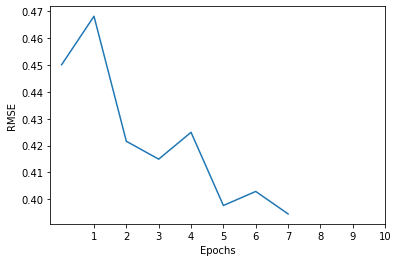

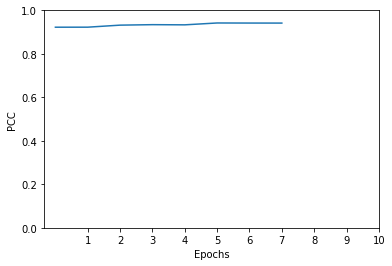

In [ ]:
#plot rmse
plt.plot(rmse)
plt.ylabel('RMSE')
plt.xticks(range(1, 11))
plt.xlabel('Epochs')
plt.savefig(join(output_result, 'rmse.png'))
plt.show()

#plot
plt.plot(pcc)
plt.ylabel('PCC')
plt.xticks(range(1, 11))
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.savefig(join(output_result, 'pcc.png'))
plt.show() 